# Ocean Data
Provided by Phoebe Lam and Mattew Marcus

In [51]:
from importlib import reload
import itertools
from ipywidgets import *

import re
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FuncAnimation, PillowWriter
import mplcursors
from matplotlib import gridspec

from scipy.interpolate import interp1d
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import umap

## Data I/O

In [2]:
directory = 'Data/XANES1/'
datafiles = os.listdir(directory)
filenames = [filename for filename in datafiles if filename.endswith('e')]
Raw_data = {filename: np.loadtxt(f'{directory}{filename}').T for filename in filenames}

In [3]:
min_e = 7011
max_e = 7415
for x, y in list(Raw_data.values()):
    minx = min(x)
    maxx = max(x)
    if minx > min_e:
        min_e = minx
    if maxx < max_e:
        max_e = maxx
print(min_e, max_e)

7051.0132 7325.0349


In [4]:
Data = {}
energy = np.linspace(int(min_e) + 1, int(max_e), 549)
for file, spectrum in Raw_data.items():
    x, y = spectrum
    interperlator = interp1d(x, y)
    interpolated_y = interperlator(energy)
    Data[file] = np.array([energy, interpolated_y])
DATA = np.array(list(Data.values()))
print(DATA.shape)

(214, 2, 549)


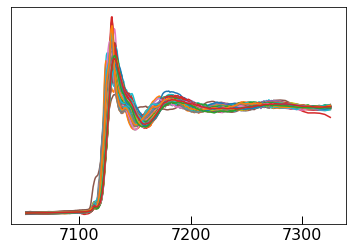

In [5]:
fig, ax = plt.subplots(figsize=(6, 4))
for i, file in enumerate(filenames):
    x, y = DATA[i]
    ax.plot(x, y, '-')
ax.set_yticks([])
ax.tick_params(direction='in', axis='x', width=1, length=8, which='major', labelsize=16)

## Visualizing data through animations

In [6]:
def plot_spectra(i):
    fig, ax = plt.subplots(figsize=(6, 4))    
    filename, spectrum = list(Data.items())[i]
    x, y = spectrum
    ax.plot(x, y, '-', linewidth=3, c=plt.cm.tab10(1), label=filename.replace('.e', ''))
    ax.text(7050, 1.85, filename.replace('.e', ''), fontsize=16)
    ax.set_yticks([])
    ax.tick_params(direction='in', axis='x', width=1, length=8, which='major', labelsize=16)
    ax.set_xlim(7040, 7335)
    ax.set_ylim(-0.1, 2.0)
        
slider = IntSlider(min=0, max=len(Data) - 1, step=1, value=0,
                   layout=widgets.Layout(width='50%'))
interactive(plot_spectra, i=slider)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='50%'), max=213), Output()), _do…

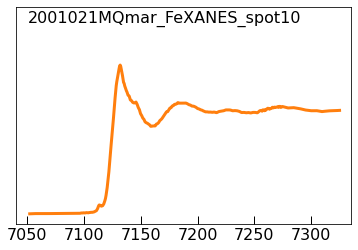

In [7]:
def animate(i):
    ax.clear()
    filename, spectrum = list(Data.items())[i]
    x, y = spectrum
    ax.plot(x, y, '-', linewidth=3, c=plt.cm.tab10(1), label=filename.replace('.e', ''))
    ax.text(7050, 1.85, filename.replace('.e', ''), fontsize=16)
    ax.set_yticks([])
    ax.tick_params(direction='in', axis='x', width=1, length=8, which='major', labelsize=16)
    ax.set_xlim(7040, 7335)
    ax.set_ylim(-0.1, 2.0)
        
fig, ax = plt.subplots(figsize=(6, 4))
ani = FuncAnimation(fig, animate, interval=5, frames=100, blit=False)    
ani.save("XANES1.gif", dpi=800, writer=PillowWriter(fps=3.5))

# Dimensionality Reduction

In [8]:
def make_scree_plot(data, n=5, threshold=0.95, show_first_PC=True, mod=0):
    """
    Make PCA scree plot.
    
    Attributes:
        data - Data on which to perform PCA analysis.
            type = ndarray
    kwargs:
        n - The number of PC's to display/ keep on the x-axis.
            default = 5
            type = int
        threshold - The variance cutoff to display.
            default = 0.95
            type = float
        show_first_PC - Opt to display the first PC.
            default = True
            type = boolean
    """
    fig, ax = plt.subplots(figsize=(8,6))
    pca = PCA()
    pca_components = pca.fit_transform(data)

    x = np.arange(n) + 1
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]

    ax.plot(x, cdf, 's-', markersize=10, fillstyle='none',
            color=plt.cm.tab10(.15))
    ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)

    if show_first_PC:
        PC1 = pca.components_[0]
        plt.plot(np.linspace(1, n, len(PC1)), -PC1*0.3 + min(cdf) + 0.05, 'k', linewidth=2)
        text = ax.text(n - 1, min(cdf) + 0.06, '$PC_1$', ha="right", va="bottom", size=20)

    if mod == 0:
        xticks = np.arange(n) + 1
    else:
        xticks = np.arange(0, n + 1, mod)
    plt.xticks(xticks, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(min(cdf) - 0.05, 1.02)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xlabel('Number of Parameters', fontsize=22)
    plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)

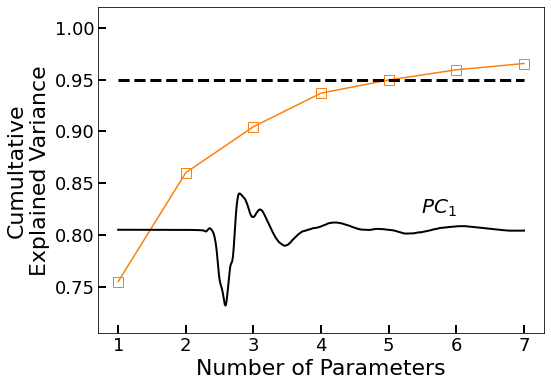

In [9]:
make_scree_plot(DATA[:, 1, :], n=7)

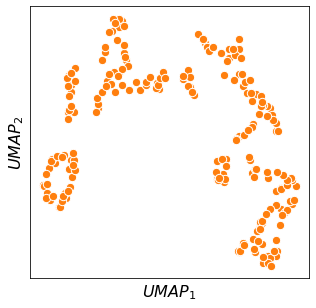

In [28]:
pca = PCA(n_components=7)
pca_components = pca.fit_transform(DATA[:, 1, :])

n_neighbors = 6
min_dist = 0.25
reducer = umap.UMAP(random_state=42, n_components=2,
                    n_neighbors=n_neighbors, min_dist=min_dist)
reduced_space = reducer.fit_transform(pca_components)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=70, 
            color=plt.cm.tab20(2), edgecolor='w')
plt.xticks([])
plt.yticks([])
ax.set_xlabel('$UMAP_1$', fontsize=16)
ax.set_ylabel('$UMAP_2$', fontsize=16)
plt.show()

In [29]:
def add_point_label(pickable, dictionary):
    """Add point label."""
    def onselect(sel):
        label = list(dictionary.keys())[sel.target.index].replace(".e", '')
        sel.annotation.set_text(label)
    mplcursors.cursor(pickable, highlight=True).connect("add", onselect)

In [30]:
%matplotlib inline

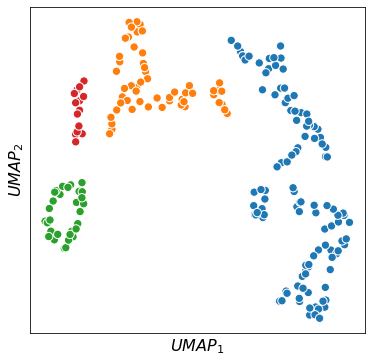

In [35]:
dbscan_clustering = DBSCAN(eps=1.2, min_samples=1).fit(reduced_space)
colors = [plt.cm.tab10(label) for label in dbscan_clustering.labels_]

fig, ax = plt.subplots(figsize=(6, 6))
points = ax.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=70, 
                     color=colors, edgecolor='w')
plt.xticks([])
plt.yticks([])
ax.set_xlabel('$UMAP_1$', fontsize=16)
ax.set_ylabel('$UMAP_2$', fontsize=16)

add_point_label(points, Data)

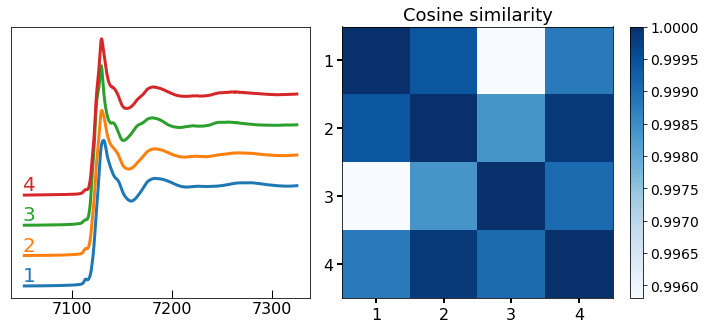

In [63]:
fig = plt.figure(figsize=(12, 5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.47, 0.53])
plt.subplots_adjust(wspace=0.1)

ax = fig.add_subplot(spec[0])
cluster_avgs = []
total_labels = np.unique(dbscan_clustering.labels_)
for label in total_labels:
    spectra = np.array([DATA[i, 1, :] for i, l in enumerate(dbscan_clustering.labels_) if l == label])
    ax.plot(energy, np.average(spectra, axis=0) + label * 0.3, '-', linewidth=3, c=plt.cm.tab10(label))
    cluster_avgs.append(np.average(spectra, axis=0))
    ax.text(7050, label * 0.3 + 0.05, label + 1, c=plt.cm.tab10(label), fontsize=20)
cluster_avgs = np.array(cluster_avgs)
ax.set_yticks([])
ax.tick_params(direction='in', axis='x', width=1, length=8, which='major', labelsize=16)

ax = fig.add_subplot(spec[1])
N = len(total_labels)
mod = 1
Similarity_matrix = np.zeros((N, N))
for i, j in itertools.product(range(N), range(N)):
    if i <= j:
        score = cosine_similarity([cluster_avgs[i]], [cluster_avgs[j]])
        Similarity_matrix[i, j] = score
        Similarity_matrix[j, i] = score
        
img = ax.imshow(Similarity_matrix, cmap='Blues', interpolation='nearest', aspect='auto')
ax.set_title('Cosine similarity', fontsize=18)
cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=14)
ax.set_yticks(np.arange(0, N, mod))
ax.set_xticks(np.arange(0, N, mod))
ax.set_yticklabels(np.arange(1, N + 1, mod))
ax.set_xticklabels(np.arange(1, N + 1, mod))
ax.tick_params(direction='out', width=2, length=5, which='major', labelsize=16)

plt.show()

Here, they LCF onto Fe refs of these cluster averages to get the general makeup of each cluster, and justify it by saying that the LCF fits to each reference generally agree, with the most prevalent components appearing in the cluster averaged fit. (vs LCF each spectrum indivually and then coming up with cluster statisitics)

# Are the clusters real? A look at $diversity$

In [65]:
total_avg = np.average(cluster_avgs, axis=0)
diversity = np.sum((cluster_avgs - total_avg)**2) / np.sum(total_avg)
print(diversity)

# todo -- random selection

0.0044724457724719755
